In [107]:
# Importing 
#pip install iorodeo-potentiostat

import math
import csv
import matplotlib.pyplot as plt
import scipy
import numpy as np
import serial
#|import pandas as pd
import scipy.stats
from scipy.signal import savgol_filter, lfilter, firwin
#from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr 

from potentiostat import Potentiostat
from time import sleep
from serial.serialutil import EIGHTBITS, PARITY_NONE, STOPBITS_TWO
from datetime import date
from datetime import time
from datetime import datetime
from csv import writer

In [108]:
# This function runs a chronoamperomic measurement

#inputs to function: 
# time(ms)0V
# voltage1 - usually 0V
# time(ms) - negative voltage 
# voltage2 - negative voltage
# time(ms) - positive voltage 
# voltage2 - positive voltage 

def run_chronoamperometry_measurement(time0,voltage0,timeN,voltageN,timeP,voltageP): 

    pstat = Potentiostat('/dev/ttyACM4') #create a device object to open serial communication
    #device name may change depending on where the USB is plugged into
    #check eaach time physical connections are changed

    test_names = pstat.get_test_names() #get a list of all supported voltametric tests

    param = pstat.get_param('chronoamp') #get test parameters for the chronoamperometry test

    param = {'quietTime': time0, 'quietValue': voltage0, 'step': [[timeN, voltageN], [timeP, voltageP]]} #set new test parameters
    #param = {'quietTime': 5000, 'quietValue': 0.0, 'step': [[5000, -2.0], [20000, 2.0]]} #set new test parameters
    #times in [ms](int), values in [V](float)
    #voltage waveform: 0V for 5sec, -2V for 5sec, 2V for 20sec
    #test parameters are stored in RAM, they need to be set again if power to the Rodeostat is ever lost

    pstat.set_param('chronoamp',param) #update the test params

    newparam = pstat.get_param('chronoamp') #check if set correctly


    #check available current measurement ranges
    curr_range_list = pstat.get_all_curr_range()

    #check current measurement range that is set right now
    curr_range = pstat.get_curr_range()

    #uncomment to set the current measurement range 
    # pstat.set_curr_range('1000uA') #set the bipolar current measeurement range
    #if readings are unknown, start high and fine tune later
    #don't want to clip the readings for the spikes (ideally)

    sample_rate = pstat.get_sample_rate() #get the sample rate of the Rodeostat, return float

    # newrate = float(10**-1) #sampling rate in [sec]
    # pstat.set_sample_rate(newrate) #set the new sampling rate, expects a float in [samples/sec]

    #alternativly, we can check the sample period
    sample_period = pstat.get_sample_period() #return the time between samples [ms], unit discrepency
    #doc says [sec] but then period != 1/rate



    device_id = pstat.get_device_id() #get the Rodeostat ID

    pstat.set_device_id(0) #assign new device ID, it is stored in nonvolatile mem, so we only need to assign it once

    new_device_id = pstat.get_device_id() #check the new Rodeostat ID


    #run chron test using the params set
    outputfile = "chrono.txt"
    t, volt, curr = pstat.run_test('chronoamp', filename=outputfile)
    #this returns a list which contains measurement times [s], voltages [V], and currents [uA] respectivly
    #output voltage range is automatically set in firmware when function is called, no need to manually change it
    #a progress bar appears across the sceen while the test is running 

    #print to screen when operation is done
    print("Chrono measurement complete\n")
    return t, volt, curr


In [109]:
# This function runs 'numberOfRuns' iterations of chronomaperometry reading and outputs the current being approached

def run_chronoamperometry_and_retrieve_current_approached(numberOfRuns):

    iterations = numberOfRuns
    time = np.zeros((numberOfRuns,3000))    # IMPORTANT: Set these values according to the data being outputted by your chonomaperometry measurements
    voltage = np.zeros((numberOfRuns,3000))
    current = np.zeros((numberOfRuns,3000))

    for i in range(iterations):
        values = np.zeros((3,3000))
        values = run_chronoamperometry_measurement(5000,0.0,5000,-2.0,20000,2.0) 
        time[i-1,:] = values[0]
        voltage[i-1,:] = values[1]
        current[i-1,:] = values[2]
        plt.plot(time[0],current[i-1])
        
    ##plot chronoamperometry measurements
    plt.xlabel('time(s)')
    plt.ylabel('current(A)')
    plt.title('Average Chronomperomtry of 5 Runs')
    plt.show()

    time_approaching = np.array(time[0][len(time[0])-100 : len(time[0])])
    current_approaching_0 = np.array(current[0][len(current[0])-100 : len(current[0])])
    current_approaching_1 = np.array(current[1][len(current[1])-100 : len(current[1])])
    current_approaching_2 = np.array(current[2][len(current[2])-100 : len(current[2])])
    current_approaching_3 = np.array(current[3][len(current[3])-100 : len(current[3])])
    current_approaching_4 = np.array(current[4][len(current[4])-100 : len(current[4])])

    #eliminate noise
    current_approaching_0_filtered = savgol_filter(current_approaching_0, 31,1)
    current_approaching_1_filtered = savgol_filter(current_approaching_1, 31,1)
    current_approaching_2_filtered = savgol_filter(current_approaching_2, 31,1)
    current_approaching_3_filtered = savgol_filter(current_approaching_3, 31,1)
    current_approaching_4_filtered = savgol_filter(current_approaching_4, 31,1)

    ## removing outliers - get 3 most correlated curves
    correlation_matrix = np.empty(shape=(10,4))
    #comparing 0,1,2
    correlation_matrix[0][0] = 0 ; correlation_matrix[0][1] = 1 ; correlation_matrix[0][2] = 2 ; correlation_matrix[0][3] = np.linalg.norm(current_approaching_0-current_approaching_1-current_approaching_2) 
    #comparing 0,1,3
    correlation_matrix[1][0] = 0 ; correlation_matrix[1][1] = 1 ; correlation_matrix[1][2] = 3 ; correlation_matrix[1][3] = np.linalg.norm(current_approaching_0-current_approaching_1-current_approaching_3) 
    #comparing 0,1,4
    correlation_matrix[2][0] = 0 ; correlation_matrix[2][1] = 1 ; correlation_matrix[2][2] = 4 ; correlation_matrix[2][3] = np.linalg.norm(current_approaching_0-current_approaching_1-current_approaching_4)             
    #comparing 0,2,3
    correlation_matrix[3][0] = 0 ; correlation_matrix[3][1] = 2 ; correlation_matrix[3][2] = 3 ; correlation_matrix[3][3] = np.linalg.norm(current_approaching_0-current_approaching_2-current_approaching_3)  
    #comparing 0,2,4
    correlation_matrix[4][0] = 0 ; correlation_matrix[4][1] = 2 ; correlation_matrix[4][2] = 4 ; correlation_matrix[4][3] = np.linalg.norm(current_approaching_0-current_approaching_2-current_approaching_4)             
    #comparing 0,3,4
    correlation_matrix[5][0] = 0 ; correlation_matrix[5][1] = 3 ; correlation_matrix[5][2] = 4 ; correlation_matrix[5][3] = np.linalg.norm(current_approaching_0-current_approaching_3-current_approaching_4)             
    #comparing 1,2,3
    correlation_matrix[6][0] = 1 ; correlation_matrix[6][1] = 2 ; correlation_matrix[6][2] = 3 ; correlation_matrix[6][3] = np.linalg.norm(current_approaching_1-current_approaching_2-current_approaching_3)
    #comparing 1,2,4
    correlation_matrix[7][0] = 1 ; correlation_matrix[7][1] = 2 ; correlation_matrix[7][2] = 4 ; correlation_matrix[7][3] = np.linalg.norm(current_approaching_1-current_approaching_2-current_approaching_4)             
    #comparing 1,3,4
    correlation_matrix[8][0] = 1 ; correlation_matrix[8][1] = 3 ; correlation_matrix[8][2] = 4 ; correlation_matrix[8][3] = np.linalg.norm(current_approaching_1-current_approaching_3-current_approaching_4)  
    #comparing 2,3,4
    correlation_matrix[9][0] = 2 ; correlation_matrix[9][1] = 3 ; correlation_matrix[9][2] = 4 ; correlation_matrix[9][3] = np.linalg.norm(current_approaching_2-current_approaching_3-current_approaching_4)                
    # putting filtered measurements in array
    filtered_measurements_array = np.empty(shape=(5,len(current_approaching_0_filtered)))
    filtered_measurements_array[0] = current_approaching_0_filtered
    filtered_measurements_array[1] = current_approaching_1_filtered  
    filtered_measurements_array[2] = current_approaching_2_filtered
    filtered_measurements_array[3] = current_approaching_3_filtered 
    filtered_measurements_array[4] = current_approaching_4_filtered
    ## getting index of mesurements that are most correlated
    bound = 1000
    measurement_indexes = np.empty(shape=(3))
    for i in range(10):
        if correlation_matrix[i-1][3] < bound :
            bound = correlation_matrix[i-1][3] ;
            measurement_indexes[0] = correlation_matrix[i-1][0]
            measurement_indexes[1] = correlation_matrix[i-1][1]
            measurement_indexes[2] = correlation_matrix[i-1][2]  
    #Plotting the 3 most CORRELATED measurements
    index_0 = int(measurement_indexes[0])
    index_1 = int(measurement_indexes[1])
    index_2 = int(measurement_indexes[2])

    # we conclude that the current being approached is the average value of average_current_approaching_filtered
    average_current_approaching_filtered = (filtered_measurements_array[index_0]+filtered_measurements_array[index_1]+filtered_measurements_array[index_2])/3
    current_being_approached = np.sum(average_current_approaching_filtered)/len(average_current_approaching_filtered)

    #plot chronoamperometry measuerements approached
    plt.plot(time_approaching,average_current_approaching_filtered)
    plt.xlabel('time(s)')
    plt.ylabel('current(uA)')
    plt.title('Current being approached after 5 Runs')
    plt.show()
    
    
    print('current being approached:', current_being_approached)
    return current_being_approached

In [110]:

#function definition(s) for Syringe Pump
def sendserial(sendstring):
    ser = serial.Serial(port='/dev/ttyUSB0', baudrate=19200, bytesize=EIGHTBITS, parity=PARITY_NONE, stopbits=STOPBITS_TWO)
    ser.close()
    try:
        ser.open()
    except Exception as e:
        print("Failed to open serial port for RS232 cable.")
        #flag=1

    if ser.isOpen():
      try:
        print("Sending:" + sendstring)
        ser.flushInput()
        ser.flushOutput()
        #ser.write(sendstring) #gives comm error
        ser.write(bytes(sendstring,'utf-8'))
        sleep(0.1) #give pump some time to process command
        out = ''
        while ser.inWaiting():
          while True:
            # Check if garbage was received from the RS-232
            try:
              # Append all of the received bytes into a single string with proper decoding
              out += ser.read().decode('utf-8') #python > 2.7
              #out += ser.read()                #python <= 2.7
              break
            except ValueError as e0:
              out = ''
              print("Recieved erroneous data:" + str(e0))
  
        if out != '':
          print("Recieved:"  + out)
        else:
          print("...Nothing received")

      except Exception as e1:
        print("Python serial communication error...:" + str(e1))
    else:
      pass

def reconnect():
    sendserial("\r") #re-establish serial communication in case touchscreen was touched
    
def updatetime():
    #Formatting date into [mm/dd/yy], ordering of units is set though the touchscreen, order must match what pump expects
    now = datetime.now()
    date = now.strftime("%x")
    print("Date: " + date)

    #Formatting time into [hh:mm:ss], 24hr time
    time12 = now.strftime("%I:%M:%S %p")
    print("Time 12hr: " + time12)
    time24 = now.strftime("%H:%M:%S")
    print("Time 24hr: " + time24 + "\n")

    cmd = "time" + " " + date + " " + time24 #updates time and date on pump to sync with comp's system time
    #cmd = "time" #returns the current date and time according to the pump
    finish = "\r\n" #<CR><LF> is equivalent to pressing enter in a serial terminal
    complete = cmd + finish #append the terminating characters so pump knows transmission is done
    sendserial(complete) #send command to pump to update the locally stored date and time
    
def sendarb(cmd):
    #used to send an arbitrary command to the pump, not a predefined function
    finish = "\r\n" #<CR><LF> is equivalent to pressing enter in a serial terminal
    complete = cmd + finish #append the terminating characters so pump knows transmission is done
    sendserial(complete) #send command to pump
    
#main script
print("--Start of Python Script--")



def send_400mL_1M_H2O2():
    reconnect()
    print("--Beginning to send 0.4mL 1M H2O2--")
    command = "civolume" #clears the infused volume
    sendarb(command)
    command = "ctvolume" #clears the target volume
    sendarb(command)
    command = "tvolume 400 u" #sets or displays the target volume, usage: tvolume [{target volume} {volume units}]
    sendarb(command)
    command = "tvolume" #displays the target volume
    sendarb(command)
    command = "irate 20 u/s" #sets or displays the infusion rate, usage: irate [max|min|lim|{rate} {rate units}]
    #for commands requiring rate units, use the following format: m, u, n, p/h, m, s. Ex: m/m = milliliter/minute, n/s = nanoliter/second
    sendarb(command)
    command = "irate" #displays the infusion rate
    sendarb(command)
    command = "crate" #displays the current rate the motor is running at. Returns 0 fl/sec when idle. 
    sendarb(command)

    command = "irun" #runs the pump in the infuse direction 
    sendarb(command)
    command = "crate" #displays the current rate the motor is running at. Returns 0 fl/sec when idle. 
    sendarb(command)
    sleep(20)

    print("--SENT 0.4mL 1M H2O2--")

--Start of Python Script--


In [111]:
#function definition(s) for PID Temp Controller
def serialsend(sendstring):
    ser = serial.Serial(port='/dev/ttyACM0', baudrate=9600, timeout=0)
    ser.close()
    try:
        ser.open()
    except Exception as e:
        print("Failed to open serial port for PID Controller.")
        #flag=1

    if ser.isOpen():
      try:
        #print("Sending:" + sendstring)
        ser.flushInput()
        ser.flushOutput()
        #ser.write(sendstring) #gives comm error
        ser.write(bytes(sendstring,'utf-8'))
        sleep(0.1) #give pump some time to process command
        out = ''
        while ser.inWaiting():
          while True:
            # Check if garbage was received from the RS-232
            try:
              # Append all of the received bytes into a single string with proper decoding
              out += ser.read().decode('utf-8') #python > 2.7
              #out += ser.read()                #python <= 2.7
              break
            except ValueError as e0:
              out = ''
              print("Recieved erroneous data:" + str(e0))
  
        if out != '':
          #print("Recieved:"  + out)
        else:
          #print("...Nothing received")

      except Exception as e1:
        print("Python serial communication error...:" + str(e1))
    else:
      pass
    
    return out

    

In [112]:
get_temp = "*G110 \r" #gets current temperature
command1 = "*R600 1 \r" #reads output mode on output 1
command2 = "*R600 2 \r" #reads output mode on output 2

command1w0 = "*W600 10 \r" #writes output mode on output 1 to output maintainted in OFF state
command1w1 = "*W600 11 \r" #writes output mode on output 1 to output control by PID function
command1w2 = "*W600 12 \r" #writes output mode on output 1 to output control by   function
outtype1 = "*G601 1 \r" #gets what output type is available for otput 1, get SSR
outtype2 = "*G601 2 \r" #gets what output type is available for otput 2, get SSR

outrange1 = "*R660 1 \r" #reads output 1 voltage output range, reads 1-10V
outrange2 = "*R660 2 \r" #reads output 2 voltage output range, reads 1-10V

runmode = "*RF23\r" #reads current system state
setmode_pause = "*WF23 9\r" #sets the system state to PAUSE
setmode_run = "*WF23 6\r" #sets the system state to RUN

def get_temp_from_PID():
    temperature = serialsend(get_temp)
    if (temperature == ''):
        print('CAUTION: Cannot connect to temperature controller')
        return -1
    else: 
        return temperature
    
def pause_PID():
    serialsend(outtype1)
    serialsend(outtype2)
    serialsend(outrange1)
    serialsend(outrange2)
    serialsend(runmode)
    serialsend(setmode_pause)
    if (serialsend(runmode) == 9): #check if controller is actually paused
        print ('Temperature controller is paused')
        return 1
    else:
        print ('CAUTION: Temperature controller is not paused. Noise may be introduced in measurement')
        return -1
     
    
def resume_PID():
    #command = "*W145 33 \r"#enable annunucator 3 on SPDT 1 Mode activated by output 1
    #serialsend(command)
    ##enable output 1  
    serialsend(command1w2)
    serialsend(runmode)
    sleep(1) #wait for some time [sec]
    serialsend(setmode_run)
    serialsend(runmode)
    if (serialsend(runmode) == 6): #check if controller is actually paused
        print ('Temperature controller is running')
        return 1
    else:
        print ('CAUTION: Temperature controller is not running. Heating functionalities may be disabled')
        return -1

In [113]:
def get_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    return current_time

In [114]:
print(get_time())


17:00:46


In [115]:
temperature = get_temp_from_PID() 

Sending:*G110 
Recieved:+25.4
+25.4


In [116]:
status = pause_PID()

Sending:*G601 1 
Recieved:004
Sending:*G601 2 
Recieved:004
Sending:*R660 1 
Recieved:0
Sending:*R660 2 
Recieved:0
Sending:*RF23
Recieved:6
Sending:*WF23 9
...Nothing received


In [117]:
resume_PID()

Sending:*W600 12 
...Nothing received
Sending:*RF23
Recieved:9
Sending:*WF23 6
...Nothing received
Sending:*RF23
Recieved:6


# Main function to automate the calibration process

In [120]:
# This function will be used to calibrate the H2O2 sensor

# Procedure:
# Begin with 400mL 0.1M PBS
# Gradually increase to 40mM by increments of 1mM
    # Add 0.4mL at a time
    # Calculate the concentration

M1 = 1000.0000000000                #concentration of H2O2 being inputed (mM)
V1 = 0.00000000000                  #inital volume of H2O2 in solution (mL) 
V2 = 400.0000000                 #inital volume of electrocemical cell (mL)


for i in range(41) :  # this loop will calibrate up to 40mM
    print('\033[1m' + str(i) + 'mM MEASUREMENT HAS BEGUN' + '\033[0m')
    print('\n')
    
    pause_PID()
    #Run chronoamperometry
    sleep(10) #wait 10 s
    current_approached = run_chronoamperometry_and_retrieve_current_approached(5) # this will return the current being approached on the chronoamperometric measurement
    sleep(10) #wait 10 s
    resume_PID()
    
    #Calculate the concentration (mM)
    concentration = M1*V1/V2
    
    #Add 0.4mL of 1M H2O2 
    send_400mL_1M_H2O2() 
    
    V1 = V1 + 0.4 
    V2 = V2 + 0.4
    
    #log temperature and time (stored in temperature and time)
    todays_date = date.today()
    time = get_time()
    temperature = get_temp_from_PID() 
    
    row = [todays_date, time, temperature, concentration, current_approached]
    print('time:', time)
    print('concentration',concentration)
    print('temp:', temperature)
    print('current approached:', current_approached)
    
    
    with open('/home/pi/Desktop/chronoLog_c alibration.txt', 'a') as f:
        writer_object = writer(f)
        writer_object.writerow(row)
        f.close()
        
    #f = open('/home/pi/Desktop/chronoLog.txt', 'w')
    #writer = csv.writer(f)
    #writer.writerow(row)
    #f.close()
    
    print('asleep \n')
    sleep(300)   #wait 5 minutes
    print('awake \n')


0mM measurement has begun
0 mM measurement has begun


Sending:*G601 1 
Recieved:004
Sending:*G601 2 
Recieved:004
Sending:*R660 1 
Recieved:0
Sending:*R660 2 
Recieved:0
Sending:*RF23
Recieved:6
Sending:*WF23 9
...Nothing received

test: chronoamp



KeyboardInterrupt: 

### TESTING AUTOLAB GPIO

In [145]:
import RPi.GPIO as GPIO
import time
 
GPIO.setmode(GPIO.BCM) #allows us to refer to pins by their "GPIO#" names vs. the physical board pin #s
 
TxToAutolab = 2 #GPIO2 = header pin 3
RxFromAutolab = 3 #GPIO3 = header pin 5

input1 = -1
print('waiting for autolab signal')
GPIO.setup(RxFromAutolab, GPIO.IN) #set Rx pin as IN

while(GPIO.input(RxFromAutolab) == 1): #wait for autolab trigger
    temp = 0
print(GPIO.input(RxFromAutolab))
print('autolab has sent a signal')

print('sending low signal to autolab')
GPIO.setup(TxToAutolab, GPIO.OUT) #set Tx pin as output
GPIO.output(TxToAutolab, GPIO.LOW) #send a 0 to the Autolab 
time.sleep(5) #wait 5s
print('chronoamperometry done')

#free resources when fully done
GPIO.cleanup()

waiting for autolab signal
0
autolab has sent a signal
sending low signal to autolab
chronoamperometry done


In [121]:
import RPi.GPIO as GPIO
import time
 
GPIO.setmode(GPIO.BCM) #allows us to refer to pins by their "GPIO#" names vs. the physical board pin #s
 
TxToAutolab = 2 #GPIO2 = header pin 3
RxFromAutolab = 3 #GPIO3 = header pin 5

GPIO.setup(TxToAutolab, GPIO.IN) #set Rx pin as IN
while(GPIO.input(RxFromAutolab)) #wait for autolab trigger
print('autolab has sent a signal')

print('sending low signal to autolab')
GPIO.setup(TxToAutolab, GPIO.OUT) #set Tx pin as output
GPIO.output(TxToAutolab, GPIO.LOW) #send a 0 to the Autolab 
time.sleep(5) #wait 5s
print('chronoamperometry done')

 
GPIO.setup(TxToAutolab, GPIO.OUT) #set Tx pin as output
GPIO.output(TxToAutolab, GPIO.LOW) #send a 0 to the Autolab
time.sleep(2) #wait 2s
 
 
time.sleep(2) #wait 200ms
print("Start squarewave")
for i in range(10): #loop 10 times. i = [0,9]
    GPIO.output(TxToAutolab, GPIO.LOW) #send a 0 to the Autolab
    time.sleep(0.2) #wait 200ms
    GPIO.output(TxToAutolab, GPIO.HIGH)  #send a 1 to the Autolab
    time.sleep(0.2) #wait 200ms
 
print("End Squarewave")
 
#free resources when fully done
GPIO.cleanup()
#this returns the pin to default state of being an input
#we won't be doing this until the whole main python sript is done and comm with the Autolab is no longer needed

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  # This is added back by InteractiveShellApp.init_path()


Start squarewave
End Squarewave


# Visual of how chronoamperometry data is being analyzed

In [ ]:
print("We get the chronoamperometric measurements")
# Plotting each graph
plt.plot(time[0], current[0], label = "Measurement 0")
plt.plot(time[1], current[1], label = "Measurement 1")
plt.plot(time[2], current[2], label = "Measurement 2")
plt.plot(time[3], current[3], label = "Measurement 3")
plt.plot(time[4], current[4], label = "Measurement 4")
plt.legend(['Measurement 0', 'Measurement 1', 'Measurement 2', 'Measurement 3', 'Measurement 4'], loc='upper left')
# naming the x axis
plt.xlabel('Time (s)')
# naming the y axis
plt.ylabel('Current(A)')
# giving a title to my graph
plt.title('Chronoamperometry- Individual')
# function to show the plot
plt.show()
    

We extract the current value being approached


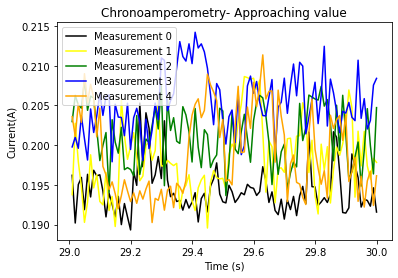

In [207]:
# Plotting Approaching value for each graph - Last 1 seconds
time_approaching = np.array(time[0][len(time[0])-100 : len(time[0])])
current_approaching_0 = np.array(current[0][len(current[0])-100 : len(current[0])])
current_approaching_1 = np.array(current[1][len(current[1])-100 : len(current[1])])
current_approaching_2 = np.array(current[2][len(current[2])-100 : len(current[2])])
current_approaching_3 = np.array(current[3][len(current[3])-100 : len(current[3])])
current_approaching_4 = np.array(current[4][len(current[4])-100 : len(current[4])])

print("We extract the current value being approached")
#Plotting Approching values - NOT Filtered
plt.plot(time_approaching, current_approaching_0, label = "Measurement 0", c = 'black')
plt.plot(time_approaching, current_approaching_1, label = "Measurement 1", c = 'yellow')
plt.plot(time_approaching, current_approaching_2, label = "Measurement 2", c = 'green')
plt.plot(time_approaching, current_approaching_3, label = "Measurement 3", c = 'blue')
plt.plot(time_approaching, current_approaching_4, label = "Measurement 4", c = 'orange') 
plt.legend(['Measurement 0', 'Measurement 1', 'Measurement 2', 'Measurement 3', 'Measurement 4'], loc='upper left')
# naming the x axis
plt.xlabel('Time (s)')
# naming the y axis
plt.ylabel('Current(A)')
# giving a title to my graph
plt.title('Chronoamperometry- Approaching value')
# function to show the plot
plt.show()

We eliminate noise from the measurements


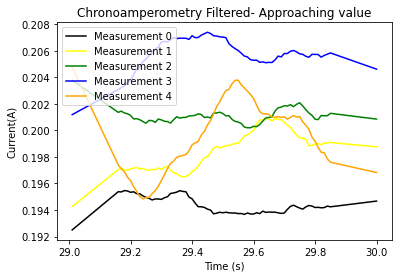

In [208]:
## Filterinig approached values
print("We eliminate noise from the measurements")
current_approaching_0_filtered = savgol_filter(current_approaching_0, 31,1)
current_approaching_1_filtered = savgol_filter(current_approaching_1, 31,1)
current_approaching_2_filtered = savgol_filter(current_approaching_2, 31,1)
current_approaching_3_filtered = savgol_filter(current_approaching_3, 31,1)
current_approaching_4_filtered = savgol_filter(current_approaching_4, 31,1)

#Plotting Approching values - FILTERED
plt.plot(time_approaching, current_approaching_0_filtered, label = "Measurement 0", c = 'black')
plt.plot(time_approaching, current_approaching_1_filtered, label = "Measurement 1", c = 'yellow')
plt.plot(time_approaching, current_approaching_2_filtered, label = "Measurement 2", c = 'green')
plt.plot(time_approaching, current_approaching_3_filtered, label = "Measurement 3", c = 'blue')
plt.plot(time_approaching, current_approaching_4_filtered, label = "Measurement 4", c = 'orange') 
plt.legend(['Measurement 0', 'Measurement 1', 'Measurement 2', 'Measurement 3', 'Measurement 4'], loc='upper left')
# naming the x axis
plt.xlabel('Time (s)')
# naming the y axis
plt.ylabel('Current(A)')
# giving a title to my graph
plt.title('Chronoamperometry Filtered- Approaching value')
# function to show the plot
plt.show()

Now we get the 3 most correlated measurements


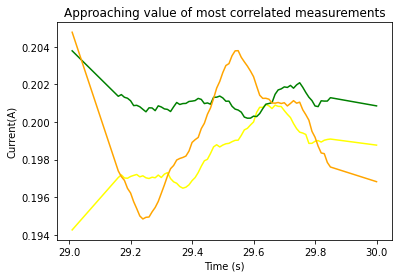

In [209]:
## removing outliers - get 3 most correlated curves
correlation_matrix = np.empty(shape=(10,4))
    
#comparing 0,1,2
correlation_matrix[0][0] = 0 ; correlation_matrix[0][1] = 1 ; correlation_matrix[0][2] = 2 ; correlation_matrix[0][3] = np.linalg.norm(current_approaching_0-current_approaching_1-current_approaching_2) 
#comparing 0,1,3
correlation_matrix[1][0] = 0 ; correlation_matrix[1][1] = 1 ; correlation_matrix[1][2] = 3 ; correlation_matrix[1][3] = np.linalg.norm(current_approaching_0-current_approaching_1-current_approaching_3) 
#comparing 0,1,4
correlation_matrix[2][0] = 0 ; correlation_matrix[2][1] = 1 ; correlation_matrix[2][2] = 4 ; correlation_matrix[2][3] = np.linalg.norm(current_approaching_0-current_approaching_1-current_approaching_4)             
#comparing 0,2,3
correlation_matrix[3][0] = 0 ; correlation_matrix[3][1] = 2 ; correlation_matrix[3][2] = 3 ; correlation_matrix[3][3] = np.linalg.norm(current_approaching_0-current_approaching_2-current_approaching_3)  
#comparing 0,2,4
correlation_matrix[4][0] = 0 ; correlation_matrix[4][1] = 2 ; correlation_matrix[4][2] = 4 ; correlation_matrix[4][3] = np.linalg.norm(current_approaching_0-current_approaching_2-current_approaching_4)             
#comparing 0,3,4
correlation_matrix[5][0] = 0 ; correlation_matrix[5][1] = 3 ; correlation_matrix[5][2] = 4 ; correlation_matrix[5][3] = np.linalg.norm(current_approaching_0-current_approaching_3-current_approaching_4)             
#comparing 1,2,3
correlation_matrix[6][0] = 1 ; correlation_matrix[6][1] = 2 ; correlation_matrix[6][2] = 3 ; correlation_matrix[6][3] = np.linalg.norm(current_approaching_1-current_approaching_2-current_approaching_3)
#comparing 1,2,4
correlation_matrix[7][0] = 1 ; correlation_matrix[7][1] = 2 ; correlation_matrix[7][2] = 4 ; correlation_matrix[7][3] = np.linalg.norm(current_approaching_1-current_approaching_2-current_approaching_4)             
#comparing 1,3,4
correlation_matrix[8][0] = 1 ; correlation_matrix[8][1] = 3 ; correlation_matrix[8][2] = 4 ; correlation_matrix[8][3] = np.linalg.norm(current_approaching_1-current_approaching_3-current_approaching_4)  
#comparing 2,3,4
correlation_matrix[9][0] = 2 ; correlation_matrix[9][1] = 3 ; correlation_matrix[9][2] = 4 ; correlation_matrix[9][3] = np.linalg.norm(current_approaching_2-current_approaching_3-current_approaching_4)             
    
# putting filtered measurements in array
filtered_measurements_array = np.empty(shape=(5,len(current_approaching_0_filtered)))
filtered_measurements_array[0] = current_approaching_0_filtered
filtered_measurements_array[1] = current_approaching_1_filtered  
filtered_measurements_array[2] = current_approaching_2_filtered
filtered_measurements_array[3] = current_approaching_3_filtered 
filtered_measurements_array[4] = current_approaching_4_filtered

## getting index of mesurements that are most correlated
bound = 1000
measurement_indexes = np.empty(shape=(3))
for i in range(10):
    if correlation_matrix[i-1][3] < bound :
        bound = correlation_matrix[i-1][3] ;
        measurement_indexes[0] = correlation_matrix[i-1][0]
        measurement_indexes[1] = correlation_matrix[i-1][1]
        measurement_indexes[2] = correlation_matrix[i-1][2]
    
#Plotting the 3 most CORRELATED measurements
index_0 = int(measurement_indexes[0])
index_1 = int(measurement_indexes[1])
index_2 = int(measurement_indexes[2])
  
print("Now we get the 3 most correlated measurements")
if index_0 == 0 or index_1 == 0 or index_2 == 0 : plt.plot(time_approaching, current_approaching_0_filtered, label = "Measurement 0", c = 'black')
if index_0 == 1 or index_1 == 1 or index_2 == 1 : plt.plot(time_approaching, current_approaching_1_filtered, label = "Measurement 1", c = 'yellow')
if index_0 == 2 or index_1 == 2 or index_2 == 2 : plt.plot(time_approaching, current_approaching_2_filtered, label = "Measurement 2", c = 'green')
if index_0 == 3 or index_1 == 3 or index_2 == 3 : plt.plot(time_approaching, current_approaching_3_filtered, label = "Measurement 3", c = 'blue')
if index_0 == 4 or index_1 == 4 or index_2 == 4 : plt.plot(time_approaching, current_approaching_4_filtered, label = "Measurement 4", c = 'orange') 
# naming the x axis
plt.xlabel('Time (s)')
# naming the y axis
plt.ylabel('Current(A)')
# giving a title to my graph
plt.title('Approaching value of most correlated measurements')
# function to show the plot
plt.show()
    

Now we take the average of the 3 most correlated measurements


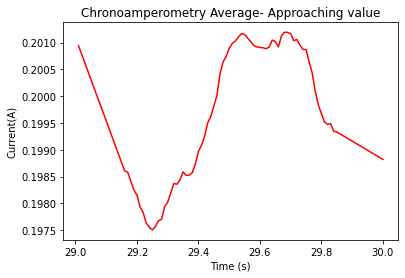

The current being approached is: 0.19961478333333335


In [210]:
# plotting average of 3 plots
## calculating average time 
average_current_approaching_filtered = (filtered_measurements_array[index_0]+filtered_measurements_array[index_1]+filtered_measurements_array[index_2])/3
#Plotting Average of 3 measurements
plt.plot(time_approaching, average_current_approaching_filtered, c = 'red')
# naming the x axis
plt.xlabel('Time (s)')
# naming the y axis
plt.ylabel('Current(A)')
# giving a title to my graph
plt.title('Chronoamperometry Average- Approaching value')
print("Now we take the average of the 3 most correlated measurements")
# function to show the plot
plt.show()
    
# we conclude that the current being approached is the average value of average_current_approaching_filtered
current_being_approached = np.sum(average_current_approaching_filtered)/len(average_current_approaching_filtered)
    
print("The current being approached is:", current_being_approached)

# Main

In [ ]:
# Importing 

import math
import csv
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import scipy.stats
from scipy.signal import savgol_filter, lfilter, firwin
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr 
import time 

# Indicate where the chronoamperometry measurements will be saved
pathToFile = "//Users/michael/Downloads/Pure Pt probe CV rev3/40mM/Chrono/"


# Run 5 Chronoamperometry Readings
## Insert Code Here for RODEOSTAT COMMAND
    
while(1):
    
    #Record Concentration Data
    #Record Temperature Data

    #Read 5 csv files and get the current that is being approached
    temp = get_concentration_from_chronoamperometry(pathToFile)
    calculatedConcentration = temp[3]
    
    #if the concentration is less than 1 mM in range, increase concentration by 1mM
    ## pump 2/5 mL of 1M H2O2
    
    #wait 7 minutes so that mixing can be done 
    time.sleep(420)
    
    